## Image网 Submission `128x128`

This contains a submission for the Image网 leaderboard in the `128x128` category.

In this notebook we:
1. Train on 1 pretext task: 
  - Train a network to do image inpatining on Image网's `/train`, `/unsup` and `/val` images. 
2. Train on 4 downstream tasks:
  - We load the pretext weights and train for `5` epochs.
  - We load the pretext weights and train for `20` epochs.
  - We load the pretext weights and train for `80` epochs.
  - We load the pretext weights and train for `200` epochs.
  
Our leaderboard submissions are the accuracies we get on each of the downstream tasks.

In [1]:
import json
import torch

import numpy as np

from functools import partial
from fastai2.basics import *
from fastai2.vision.all import *

In [2]:
torch.cuda.set_device(1)

## Pretext Task: Contrastive Learning

In [3]:
# Chosen parameters
lr=2e-2
sqrmom=0.99
mom=0.95
beta=0.
eps=1e-6
bs=64 
sa=1

m = xresnet34
act_fn = Mish
pool = MaxPool

nc=20

In [4]:
source = untar_data(URLs.IMAGEWANG_160)
len(get_image_files(source/'unsup')), len(get_image_files(source/'train')), len(get_image_files(source/'val'))

(7750, 14669, 3929)

In [5]:
def get_dbunch(size, bs, workers=8):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source, folders=['unsup', 'val'])
    
    tfms = [[PILImage.create, ToTensor, Resize(size)], 
            [lambda x: x.parent.name, Categorize()]]
    
#     dsets = Datasets(files, tfms=tfms, splits=GrandparentSplitter(train_name='unsup', valid_name='val')(files))
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    dls.path = source
    return dls

In [6]:
# Use the Ranger optimizer
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [7]:
size = 128
bs = 256

dbunch = get_dbunch(160, bs)
# dbunch.c = nc
dbunch.c = 128

In [8]:
len(dbunch.train.dataset)

10512

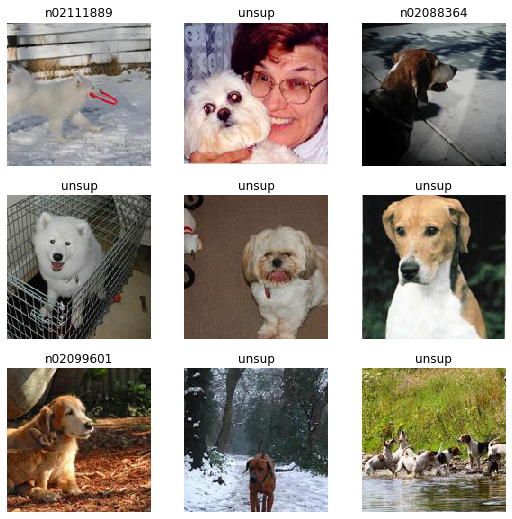

In [9]:
dbunch.show_batch()

In [10]:
#export
from pytorch_metric_learning import losses
class XentLoss(losses.NTXentLoss):
    def forward(self, output1, output2):
        stacked = torch.cat((output1, output2), dim=0)
        labels = torch.arange(output1.shape[0]).repeat(2)
        return super().forward(stacked, labels, None)
    
class ContrastCallback(Callback):
    run_before=Recorder
    def __init__(self, size=256, aug_targ=None, aug_pos=None, temperature=0.1):
        self.aug_targ = ifnone(aug_targ, get_aug_pipe(size, min_scale=0.7))
        self.aug_pos = ifnone(aug_pos, get_aug_pipe(size, min_scale=0.4))
        self.temperature = temperature
        
    def update_size(self, size):
        pipe_update_size(self.aug_targ, size)
        pipe_update_size(self.aug_pos, size)
        
    def begin_fit(self): 
        self.old_lf = self.learn.loss_func
        self.old_met = self.learn.metrics
        self.learn.metrics = []
        self.learn.loss_func = losses.NTXentLoss(self.temperature)
        
    def after_fit(self):
        self.learn.loss_fun = self.old_lf
        self.learn.metrics = self.old_met
        
    def begin_batch(self):
        xb, = self.learn.xb
        xb_targ = self.aug_targ(xb)
        xb_pos = self.aug_pos(xb)
        self.learn.xb = torch.cat((xb_targ, xb_pos), dim=0),
        self.learn.yb = torch.arange(xb_targ.shape[0]).repeat(2),
        

In [11]:
#export
def pipe_update_size(pipe, size):
    for tf in pipe.fs:
        if isinstance(tf, RandomResizedCropGPU):
            tf.size = size

In [12]:
#export
def get_aug_pipe(size, min_scale=0.4, stats=imagenet_stats, erase=True, **kwargs):
    tfms = [Normalize.from_stats(*stats), *aug_transforms(size=size, min_scale=min_scale, **kwargs)]
    if erase: tfms.append(RandomErasing(p=0.5, max_count=1, sh=0.2))
    return Pipeline(tfms)

In [13]:
m_part = partial(m, c_out=nc, act_cls=torch.nn.ReLU, sa=sa, pool=pool)

In [14]:
save_name = 'imagewang_contrast_simple_dogsonly'

In [15]:
aug = get_aug_pipe(size, min_scale=0.3, mult=1, max_lighting=0.4, stats=imagenet_stats)
aug2 = get_aug_pipe(size, min_scale=0.25, mult=2, max_lighting=0.3, stats=imagenet_stats)
cbs = ContrastCallback(size=size, aug_targ=aug, aug_pos=aug2)

learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                    metrics=[], loss_func=CrossEntropyLossFlat(), cbs=cbs, pretrained=False,
                    config={'ps':0.0, 'concat_pool':False}
                   )

In [16]:
learn.model

Sequential(
  (0): Sequential(
    (0): ConvLayer(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ConvLayer(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): ConvLayer(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): ResBlock(
        (convpath): Sequential(
          (0): ConvLayer(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): Ba

In [17]:
learn.unfreeze()
learn.fit_flat_cos(30, 2e-2, wd=1e-2)

epoch,train_loss,valid_loss,time
0,1.255938,1.992538,00:25
1,0.817179,1.054931,00:21
2,0.645923,0.800283,00:21
3,0.496229,0.415526,00:21
4,0.443635,0.480908,00:21
5,0.475458,1.123300,00:21
6,0.453165,0.665472,00:21
7,0.450516,0.893748,00:21
8,0.412665,1.008999,00:21
9,0.438938,0.557601,00:21


In [18]:
torch.save(learn.model[0].state_dict(), f'{save_name}.pth')

In [ ]:
# learn.save(save_name)

## Downstream Task: Image Classification

In [19]:
def get_dbunch(size, bs, workers=8, dogs_only=True):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    if dogs_only:
        dog_categories = [f.name for f in (source/'val').ls()]
        dog_train = get_image_files(source/'train', folders=dog_categories)
        valid = get_image_files(source/'val')
        files = dog_train + valid
        splits = [range(len(dog_train)), range(len(dog_train), len(dog_train)+len(valid))]
    else:
        files = get_image_files(source)
        splits = GrandparentSplitter(valid_name='val')(files)
        
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [lambda x: x.parent.name, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=splits)
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    dls.path = source
    return dls

In [42]:
def do_train(size=128, bs=64, epochs=5, runs=5, dogs_only=False, save_name=None):
    dbunch = get_dbunch(size, bs, dogs_only=dogs_only)
    for run in range(runs):
        print(f'Run: {run}')
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
                pretrained=False,
                config={'custom_head':ch})

        if save_name is not None:
            state_dict = torch.load(f'{save_name}.pth')
            learn.model[0].load_state_dict(state_dict)

        learn.unfreeze()
        learn.fit_flat_cos(epochs, 2e-2, wd=1e-2)

### 5 Epochs

In [43]:
epochs = 5
runs = 5

In [44]:
do_train(epochs=epochs, runs=runs, dogs_only=False, save_name=save_name)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.264316,2.751280,0.167218,0.685925,00:20
1,1.012667,3.231696,0.156019,0.592263,00:20
2,0.887092,3.167798,0.164673,0.601425,00:22
3,0.807817,2.702457,0.222957,0.665818,00:20
4,0.589690,2.063611,0.394757,0.820311,00:19


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.298580,2.719787,0.144312,0.651311,00:19
1,1.012432,2.734107,0.207686,0.683635,00:19
2,0.916316,2.885706,0.158565,0.602189,00:19
3,0.810893,2.764042,0.203614,0.650293,00:20
4,0.586410,2.093648,0.381522,0.815220,00:19


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.299704,3.226075,0.089081,0.488419,00:21
1,1.047462,3.113448,0.143039,0.680580,00:20
2,0.920647,3.821814,0.095190,0.457114,00:19
3,0.796662,2.843070,0.227539,0.695597,00:20
4,0.626396,2.164477,0.363960,0.804530,00:19


Run: 3


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.262152,3.442899,0.104607,0.497582,00:19
1,1.023958,3.417553,0.113515,0.489183,00:20
2,0.906248,2.970151,0.202851,0.669381,00:20
3,0.808080,2.633732,0.248664,0.735302,00:19
4,0.601570,2.088897,0.380504,0.826164,00:19


Run: 4


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.284982,3.467605,0.114787,0.442606,00:19
1,1.026513,2.617527,0.206414,0.765080,00:20
2,0.894682,2.497702,0.277170,0.773988,00:20
3,0.804725,2.667945,0.266480,0.686943,00:20
4,0.617504,2.092920,0.384576,0.816238,00:20


## Dogs only

In [45]:
do_train(epochs=epochs, runs=runs, dogs_only=True, save_name=save_name)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.503247,2.125004,0.223212,0.743192,00:04
1,2.113185,1.854264,0.341054,0.831255,00:04
2,1.873531,1.947706,0.356325,0.842963,00:04
3,1.694754,2.090223,0.339527,0.831509,00:04
4,1.531995,1.660682,0.420972,0.885722,00:04


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.499898,2.070999,0.250954,0.769152,00:04
1,2.082829,2.090147,0.310003,0.821583,00:04
2,1.859262,2.271535,0.344871,0.849835,00:04
3,1.699689,1.994309,0.340290,0.846271,00:04
4,1.538282,1.630802,0.424281,0.890048,00:04


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.451681,2.061752,0.251718,0.764826,00:04
1,2.074064,2.045066,0.295241,0.807585,00:04
2,1.843813,1.887136,0.349962,0.851362,00:04
3,1.676487,1.806102,0.392212,0.857979,00:04
4,1.505266,1.663836,0.421481,0.890303,00:04


Run: 3


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.477502,2.075664,0.269025,0.745228,00:04
1,2.067858,1.977354,0.308221,0.834054,00:04
2,1.838849,2.199848,0.286332,0.810639,00:04
3,1.686155,2.222782,0.349962,0.835073,00:04
4,1.537908,1.642993,0.432935,0.884194,00:04


Run: 4


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.524758,2.073293,0.248664,0.756936,00:04
1,2.111630,2.240511,0.288878,0.797404,00:04
2,1.881065,2.104455,0.347417,0.833291,00:04
3,1.701058,2.034327,0.332146,0.840417,00:04
4,1.536142,1.657095,0.434462,0.884958,00:04


## Random weights - ACC = 0.337999	

In [46]:
do_train(epochs=epochs, runs=1, dogs_only=False, save_name=None)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.435147,3.005354,0.101553,0.553576,00:20
1,1.150493,3.258300,0.086281,0.564266,00:20
2,0.999083,2.801569,0.185034,0.668109,00:22
3,0.861181,3.723441,0.078391,0.372105,00:20
4,0.677000,2.212543,0.322219,0.798422,00:20


### 20 Epochs

In [47]:
epochs = 20
runs = 3

In [48]:
do_train(epochs=epochs, runs=runs, dogs_only=False, save_name=save_name)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.257433,3.583709,0.055994,0.364469,00:20
1,1.004941,2.540476,0.226266,0.740137,00:20
2,0.918966,2.997299,0.198015,0.653856,00:20
3,0.836182,2.604789,0.273097,0.694833,00:20
4,0.748276,2.963373,0.203360,0.616951,00:20
5,0.699710,2.427061,0.329091,0.763808,00:20
6,0.655900,2.179317,0.365996,0.777806,00:20
7,0.591791,2.329697,0.374905,0.804021,00:20
8,0.565931,2.494817,0.358106,0.809875,00:21
9,0.509965,3.094292,0.247900,0.684907,00:21


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.269204,3.301069,0.131840,0.571901,00:20
1,1.017692,3.388632,0.125732,0.501909,00:19
2,0.912226,2.442005,0.233138,0.707050,00:20
3,0.789521,2.612660,0.275134,0.776024,00:20
4,0.749869,2.766610,0.218631,0.664800,00:21
5,0.693362,2.476660,0.308221,0.733774,00:21
6,0.627887,1.994382,0.402392,0.825146,00:20
7,0.610023,2.508790,0.275897,0.775515,00:20
8,0.557153,2.561898,0.327055,0.795368,00:19
9,0.534639,2.271221,0.400611,0.792059,00:20


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.240680,3.091946,0.109952,0.579791,00:19
1,1.009205,3.817732,0.069483,0.404938,00:19
2,0.899343,2.559685,0.273097,0.717485,00:19
3,0.810252,2.767231,0.257317,0.658946,00:20
4,0.736861,3.026284,0.189361,0.641894,00:19
5,0.695508,2.357419,0.330109,0.784933,00:20
6,0.649655,2.246459,0.368033,0.789259,00:19
7,0.593011,2.521852,0.298804,0.762026,00:19
8,0.561426,2.237053,0.390685,0.779079,00:20
9,0.542249,2.700214,0.313311,0.759735,00:19


In [49]:
do_train(epochs=epochs, runs=runs, dogs_only=True, save_name=save_name)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.419962,2.028534,0.256299,0.785442,00:04
1,2.068397,1.927915,0.340799,0.837618,00:04
2,1.836570,1.829464,0.375414,0.856707,00:04
3,1.650049,1.788423,0.371850,0.855179,00:04
4,1.525810,2.122462,0.349962,0.862051,00:04
5,1.409127,1.766814,0.418682,0.890048,00:04
6,1.299878,1.839168,0.419700,0.889539,00:04
7,1.181091,2.027332,0.382540,0.852125,00:04
8,1.068881,2.562188,0.360652,0.867142,00:04
9,0.998522,3.198325,0.262153,0.768389,00:04


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.524388,2.106344,0.262662,0.750827,00:04
1,2.107952,2.152911,0.297022,0.804021,00:04
2,1.861961,1.987980,0.343344,0.840926,00:04
3,1.688572,2.183270,0.326037,0.851871,00:04
4,1.561960,2.091644,0.357343,0.850089,00:04
5,1.440466,1.704883,0.426826,0.880886,00:04
6,1.331598,1.737935,0.439298,0.886485,00:04
7,1.238203,2.150035,0.336472,0.837363,00:04
8,1.134059,2.150047,0.413082,0.884703,00:04
9,1.041700,2.500204,0.341817,0.835582,00:04


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.451651,2.026117,0.285823,0.769661,00:04
1,2.067972,2.076253,0.327819,0.823874,00:04
2,1.841168,2.055392,0.319420,0.833036,00:04
3,1.671154,1.949597,0.349198,0.839908,00:04
4,1.542939,1.997064,0.345635,0.852889,00:04
5,1.430499,1.704565,0.414355,0.882413,00:04
6,1.312951,1.825053,0.418682,0.896920,00:04
7,1.207103,1.924473,0.404938,0.877322,00:04
8,1.083943,2.114199,0.394248,0.864088,00:04
9,1.015734,2.158743,0.385085,0.867142,00:04


## 80 epochs

In [ ]:
epochs = 80
runs = 1

In [ ]:
for run in range(runs):
    print(f'Run: {run}')
    ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
    learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
            metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
            pretrained=False,
            config={'custom_head':ch})
    learn.unfreeze()
    learn.fit_flat_cos(epochs, 2e-2, wd=1e-3)

Accuracy: **62.18%**

### 200 epochs

In [ ]:
epochs = 200
runs = 1

In [ ]:
for run in range(runs):
        print(f'Run: {run}')
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
                config={'custom_head':ch})#, cbs=cbs)
        
        if dump: print(learn.model); exit()
#         if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        learn.load(ss_name, strict=True)
        
        learn.freeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Accuracy: **62.03%**